In [1]:
!pip install -U langchain langchain-community chromadb sentence-transformers transformers


In [2]:
import pandas as pd

df = pd.read_csv("/content/german.csv", sep=';')

def to_case(row):
    return (
        f"Applicant is {row['Sex_Marital_Status']}, works as {row['Occupation']}, "
        f"Age: {row['Age_years']}, Loan Amount: {row['Credit_Amount']} for {row['Purpose']} purpose, "
        f"Credit History: {row['Payment_Status_of_Previous_Credit']}, "
        f"Savings: {row['Value_Savings_Stocks']}, Employment Duration: {row['Length_of_current_employment']}, "
        f"Assets: {row['Most_valuable_available_asset']}, Creditability: {row['Creditability']}."
    )

df["narrative"] = df.apply(to_case, axis=1)


In [3]:
from langchain.vectorstores import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.docstore.document import Document

docs = [Document(page_content=text) for text in df['narrative'].tolist()]
embedding_model = SentenceTransformerEmbeddings(model_name='all-MiniLM-L6-v2')

vectorstore = Chroma.from_documents(docs, embedding_model, persist_directory="./chroma_loan_db")
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})


<ipython-input-3-025c49f53528>:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = SentenceTransformerEmbeddings(model_name='all-MiniLM-L6-v2')
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
 

In [4]:

# For models like FLAN-T5, LaMini-Flan (encoder-decoder models)
from transformers import pipeline

def load_text2text_pipeline(model_name):
    """
    Loads a text2text-generation model.
    Example: FLAN-T5, LaMini-Flan.
    """
    return pipeline("text2text-generation", model=model_name, device_map="auto")

# For models like Falcon, GPT2 (decoder-only models)
def load_text_generation_pipeline(model_name):
    """
    Loads a text-generation model.
    Example: Falcon, GPT2, etc.
    """
    return pipeline("text-generation", model=model_name, device_map="auto")



In [5]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from langchain.llms import HuggingFacePipeline

def load_seq2seq_llm(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer)
    return HuggingFacePipeline(pipeline=pipe)

def load_causal_llm(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
    return HuggingFacePipeline(pipeline=pipe)

models = {
    "FLAN-T5-Base": HuggingFacePipeline(pipeline=load_text2text_pipeline("google/flan-t5-base")),
      "LaMini-Flan-T5-248M": HuggingFacePipeline(pipeline=load_text2text_pipeline("MBZUAI/LaMini-Flan-T5-248M")),
    "Falcon-RW-1B": HuggingFacePipeline(pipeline=load_text_generation_pipeline("tiiuae/falcon-rw-1b"))
}


Device set to use cuda:0
<ipython-input-5-69b781fa5548>:17: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  "FLAN-T5-Base": HuggingFacePipeline(pipeline=load_text2text_pipeline("google/flan-t5-base")),
Device set to use cuda:0
Device set to use cuda:0


In [6]:
from langchain.prompts import PromptTemplate

# For FLAN models (already working)
flan_prompt_template = PromptTemplate.from_template(
    "Answer the question using the context.\nContext:\n{context}\n\nQuestion: {question}"
)

# For Falcon-RW-1B (few-shot example added)
falcon_prompt_template = PromptTemplate.from_template(
    "You are a loan risk evaluator. Answer clearly based on the context.\n\n"
    "Example:\n"
    "Context: Applicant is employed with stable income and high savings.\n"
    "Question: Should we approve a loan?\n"
    "Answer: Yes, the applicant is low risk.\n\n"
    "Now:\n"
    "Context:\n{context}\n\nQuestion:\n{question}\nAnswer:"
)
from langchain.chains import RetrievalQA

chains = {
    "FLAN-T5-Base": RetrievalQA.from_chain_type(
        llm=models["FLAN-T5-Base"],
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": flan_prompt_template}
    ),
     "LaMini-Flan-T5-248M": RetrievalQA.from_chain_type(
        llm=models["LaMini-Flan-T5-248M"],
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": flan_prompt_template}
    ),
    "Falcon-RW-1B": RetrievalQA.from_chain_type(
        llm=models["Falcon-RW-1B"],
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": falcon_prompt_template}
    )
}


In [7]:
loan_questions = [
    "Should we approve a loan for an applicant with high savings and stable employment?",
    "Is it risky to approve loans for applicants with poor credit history?",
    "Does being a foreign worker impact loan approval chances?",
    "How does the duration at current address affect loan approval?",
    "Is it safer to lend to applicants with multiple guarantors?",
    "How important is age in assessing loan eligibility?",
    "Does longer employment duration reduce loan risk?",
    "What factors increase the chances of loan default?",
    "Should applicants with no valuable assets be approved easily?",
    "How does the number of credits at this bank affect approval chances?"
]


In [8]:
def compare_models(chains, questions):
    model_responses = {name: [] for name in chains.keys()}

    for idx, q in enumerate(questions):
        print(f"\n📚 Question {idx+1}: {q}\n{'='*70}")

        for name, chain in chains.items():
            try:
                raw_answer = chain.run(q)

                # Special cleaning for Falcon outputs
                if name == "Falcon-RW-1B":
                    answer = raw_answer.split("Answer:")[-1].strip().split("\n")[0]
                else:
                    answer = raw_answer.strip()

                model_responses[name].append(answer)
                print(f" {name}:\n{answer}\n{'-'*50}")
            except Exception as e:
                model_responses[name].append("Error")
                print(f" {name}: Error - {e}")

    return model_responses


In [9]:
model_answers = compare_models(chains, loan_questions)



<ipython-input-8-bd56e47be95b>:9: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  raw_answer = chain.run(q)



📚 Question 1: Should we approve a loan for an applicant with high savings and stable employment?
 FLAN-T5-Base:
Yes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M:
Yes, we should approve a loan for an applicant with high savings and stable employment.
--------------------------------------------------
 Falcon-RW-1B:
Yes, the applicant is low risk.
--------------------------------------------------

📚 Question 2: Is it risky to approve loans for applicants with poor credit history?
 FLAN-T5-Base:
no
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M:
It is not possible to determine whether it is risky to approve loans for applicants with poor credit history
--------------------------------------------------
 Falcon-RW-1B:
No, it is not risky to approve loans for applicants with poor credit history.
--------------------------------------------------

📚 Question 3: Does being a foreign worker impact loan approval chances?
 FLAN-T5-Base:
Yes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M:
The context does not provide information about whether being a foreign worker impacts loan approval chances.
--------------------------------------------------
 Falcon-RW-1B:
No, it does not.
--------------------------------------------------

📚 Question 4: How does the duration at current address affect loan approval?
 FLAN-T5-Base:
3
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M:
The duration at current address affects loan approval by determining the amount of loan amount and the duration
--------------------------------------------------
 Falcon-RW-1B:
The duration at current address is not a factor.
--------------------------------------------------

📚 Question 5: Is it safer to lend to applicants with multiple guarantors?
 FLAN-T5-Base:
yes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M:
It is not possible to determine whether it is safer to lend to applicants with multiple guaran
--------------------------------------------------
 Falcon-RW-1B:
Yes, it is safer to lend to applicants with multiple guarantors.
--------------------------------------------------

📚 Question 6: How important is age in assessing loan eligibility?
 FLAN-T5-Base:
23
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M:
Age is very important in assessing loan eligibility.
--------------------------------------------------
 Falcon-RW-1B:
Age is important in assessing loan eligibility.
--------------------------------------------------

📚 Question 7: Does longer employment duration reduce loan risk?
 FLAN-T5-Base:
Yes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M:
The context does not provide information about whether longer employment duration reduces loan risk.
--------------------------------------------------
 Falcon-RW-1B:
No, it does not.
--------------------------------------------------

📚 Question 8: What factors increase the chances of loan default?
 FLAN-T5-Base:
Age: 26, Loan Amount: 9960 for 2 purpose, Credit History: 2, Savings:
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M:
The factors that increase the chances of loan default are the applicant's credit history, savings history,
--------------------------------------------------
 Falcon-RW-1B:
- Low income
--------------------------------------------------

📚 Question 9: Should applicants with no valuable assets be approved easily?
 FLAN-T5-Base:
No
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M:
No, applicants with no valuable assets should not be approved easily.
--------------------------------------------------
 Falcon-RW-1B:
No.
--------------------------------------------------

📚 Question 10: How does the number of credits at this bank affect approval chances?
 FLAN-T5-Base:
The number of credits at this bank affects approval chances.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M:
The number of credits at this bank affects approval chances by determining the applicant's credit history
--------------------------------------------------
 Falcon-RW-1B:
The number of credits at this bank is 2.
--------------------------------------------------


In [10]:
def calculate_final_accuracy_and_time(model_results):
    accuracies = {}
    avg_times = {}

    for model, results in model_results.items():
        correct_answers = results["correct"]
        times = results["times"]

        accuracy = sum(correct_answers) / len(correct_answers) if correct_answers else 0
        avg_time = sum(times) / len(times) if times else 0

        accuracies[model] = accuracy
        avg_times[model] = avg_time

    return accuracies, avg_times



In [11]:
import time

def evaluate_models_with_accuracy_and_time(chains, questions, expected_keywords):
    model_results = {name: {"responses": [], "correct": [], "times": []} for name in chains.keys()}

    for idx, q in enumerate(questions):
        print(f"\nQuestion {idx+1}: {q}\n{'='*70}")

        for name, chain in chains.items():
            try:
                start_time = time.time()
                raw_answer = chain.run(q)
                end_time = time.time()

                # --- FIX: handle list outputs from models like LaMini, Falcon
                if isinstance(raw_answer, list):
                    raw_answer = raw_answer[0]["generated_text"]

                # Special cleaning for Falcon
                if name == "Falcon-RW-1B":
                    answer = raw_answer.split("Answer:")[-1].strip().split("\n")[0]
                else:
                    answer = raw_answer.strip()

                model_results[name]["responses"].append(answer)
                model_results[name]["times"].append(end_time - start_time)

                answer_lower = answer.lower()
                expected_list = expected_keywords.get(idx, [])

                # Check if any keyword matches
                if any(keyword.lower() in answer_lower for keyword in expected_list):
                    model_results[name]["correct"].append(1)
                else:
                    model_results[name]["correct"].append(0)

                print(f" {name}: {answer}\n{'-'*50}")

            except Exception as e:
                model_results[name]["responses"].append("Error")
                model_results[name]["correct"].append(0)
                model_results[name]["times"].append(9999)
                print(f" {name}: Error - {e}")

    return model_results


In [12]:
# Define your expected short answers
expected_answers = {
    0: ["savings", "employment", "stable","yes"],
    1: ["credit history", "risk", "poor","yes"],
    2: ["yes"],
    3: ["current address", "loan", "approval","duration"],
    4: ["guarantor", "safe", "lending","yes"],
    5: ["age", "loan eligibility"],
    6: ["employment duration", "loan risk","yes"],
    7: ["default", "factors"],
    8: ["assets", "loan approval","no"],
    9: ["number of credits", "bank", "approval"]
}

# Step 1: Evaluate all models
model_results = evaluate_models_with_accuracy_and_time(chains, loan_questions, expected_answers)

# Step 2: Calculate final accuracy and average response time
accuracies, avg_times = calculate_final_accuracy_and_time(model_results)

# Step 3: Print nicely
print("\n Model Accuracy and Time Report:")
for model in accuracies:
    print(f" {model}: Accuracy = {accuracies[model]*100:.1f}%, Avg Time = {avg_times[model]:.2f} sec")


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Question 1: Should we approve a loan for an applicant with high savings and stable employment?
 FLAN-T5-Base: Yes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: Yes, we should approve a loan for an applicant with high savings and stable employment.
--------------------------------------------------
 Falcon-RW-1B: Yes, the applicant is low risk.
--------------------------------------------------

Question 2: Is it risky to approve loans for applicants with poor credit history?
 FLAN-T5-Base: no
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: It is not possible to determine whether it is risky to approve loans for applicants with poor credit history
--------------------------------------------------
 Falcon-RW-1B: No, it is not risky to approve loans for applicants with poor credit history.
--------------------------------------------------

Question 3: Does being a foreign worker impact loan approval chances?
 FLAN-T5-Base: Yes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: The context does not provide information about whether being a foreign worker impacts loan approval chances.
--------------------------------------------------
 Falcon-RW-1B: No, it does not.
--------------------------------------------------

Question 4: How does the duration at current address affect loan approval?
 FLAN-T5-Base: 3
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: The duration at current address affects loan approval by determining the amount of loan amount and the duration
--------------------------------------------------
 Falcon-RW-1B: The duration at current address is not a factor.
--------------------------------------------------

Question 5: Is it safer to lend to applicants with multiple guarantors?
 FLAN-T5-Base: yes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: It is not possible to determine whether it is safer to lend to applicants with multiple guaran
--------------------------------------------------
 Falcon-RW-1B: Yes, it is safer to lend to applicants with multiple guarantors.
--------------------------------------------------

Question 6: How important is age in assessing loan eligibility?
 FLAN-T5-Base: 23
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: Age is very important in assessing loan eligibility.
--------------------------------------------------
 Falcon-RW-1B: Age is important in assessing loan eligibility.
--------------------------------------------------

Question 7: Does longer employment duration reduce loan risk?
 FLAN-T5-Base: Yes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: The context does not provide information about whether longer employment duration reduces loan risk.
--------------------------------------------------
 Falcon-RW-1B: No, it does not.
--------------------------------------------------

Question 8: What factors increase the chances of loan default?
 FLAN-T5-Base: Age: 26, Loan Amount: 9960 for 2 purpose, Credit History: 2, Savings:
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: The factors that increase the chances of loan default are the applicant's credit history, savings history,
--------------------------------------------------
 Falcon-RW-1B: - Low income
--------------------------------------------------

Question 9: Should applicants with no valuable assets be approved easily?
 FLAN-T5-Base: No
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: No, applicants with no valuable assets should not be approved easily.
--------------------------------------------------
 Falcon-RW-1B: No.
--------------------------------------------------

Question 10: How does the number of credits at this bank affect approval chances?
 FLAN-T5-Base: The number of credits at this bank affects approval chances.
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: The number of credits at this bank affects approval chances by determining the applicant's credit history
--------------------------------------------------
 Falcon-RW-1B: The number of credits at this bank is 2.
--------------------------------------------------

 Model Accuracy and Time Report:
 FLAN-T5-Base: Accuracy = 60.0%, Avg Time = 0.13 sec
 LaMini-Flan-T5-248M: Accuracy = 90.0%, Avg Time = 0.38 sec
 Falcon-RW-1B: Accuracy = 70.0%, Avg Time = 0.69 sec


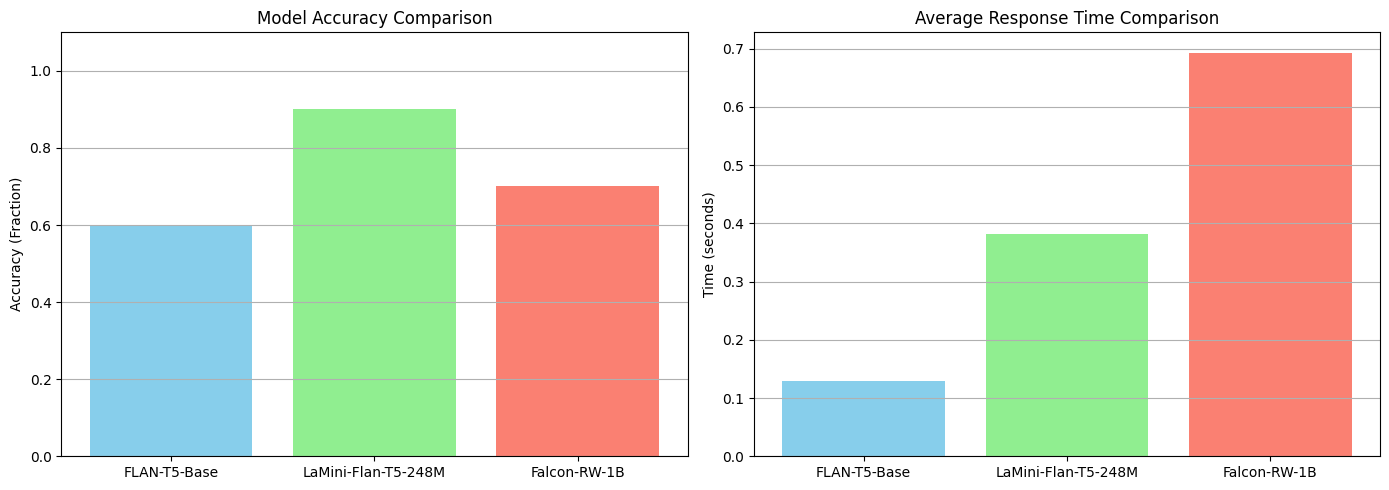

In [13]:
import matplotlib.pyplot as plt

# Step 1: Prepare the data
model_names = list(accuracies.keys())
accuracy_values = list(accuracies.values())
time_values = list(avg_times.values())

# Step 2: Plot side-by-side charts
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# 2a. Accuracy Chart
axs[0].bar(model_names, accuracy_values, color=['skyblue', 'lightgreen', 'salmon'])
axs[0].set_title("Model Accuracy Comparison")
axs[0].set_ylabel("Accuracy (Fraction)")
axs[0].set_ylim(0, 1.1)
axs[0].grid(axis='y')

# 2b. Average Response Time Chart
axs[1].bar(model_names, time_values, color=['skyblue', 'lightgreen', 'salmon'])
axs[1].set_title("Average Response Time Comparison")
axs[1].set_ylabel("Time (seconds)")
axs[1].grid(axis='y')

# Layout adjustment
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# Assume you already have:
# model_results = output from evaluate_models_keyword_based()
# loan_questions = list of your 10 loan questions

# Step 1: Extract model responses
model_answers = {}

for model, data in model_results.items():
    model_answers[model] = data["responses"]

# Step 2: Build the comparison table
comparison_data = {
    "Question": loan_questions
}


for model in model_answers.keys():
    comparison_data[model] = model_answers[model]

# Step 3: Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Step 4: Display the table
comparison_df


,Question,FLAN-T5-Base,LaMini-Flan-T5-248M,Falcon-RW-1B
0,Should we approve a loan for an applicant with...,Yes,"Yes, we should approve a loan for an applicant...","Yes, the applicant is low risk."
1,Is it risky to approve loans for applicants wi...,no,It is not possible to determine whether it is ...,"No, it is not risky to approve loans for appli..."
2,Does being a foreign worker impact loan approv...,Yes,The context does not provide information about...,"No, it does not."
3,How does the duration at current address affec...,3,The duration at current address affects loan a...,The duration at current address is not a factor.
4,Is it safer to lend to applicants with multipl...,yes,It is not possible to determine whether it is ...,"Yes, it is safer to lend to applicants with mu..."
5,How important is age in assessing loan eligibi...,23,Age is very important in assessing loan eligib...,Age is important in assessing loan eligibility.
6,Does longer employment duration reduce loan risk?,Yes,The context does not provide information about...,"No, it does not."
7,What factors increase the chances of loan defa...,"Age: 26, Loan Amount: 9960 for 2 purpose, Cred...",The factors that increase the chances of loan ...,- Low income
8,Should applicants with no valuable assets be a...,No,"No, applicants with no valuable assets should ...",No.
9,How does the number of credits at this bank af...,The number of credits at this bank affects app...,The number of credits at this bank affects app...,The number of credits at this bank is 2.


In [15]:
# Assume you already have your chains dictionary ready
# Example: chains = {"FLAN-T5-Base": chain1, "FLAN-T5-Large": chain2, "Falcon-RW-1B": chain3}

while True:
    # Ask user for a question
    user_question = input("\n Enter your question (or type 'exit' to stop): ")

    if user_question.lower() == 'exit':
        print(" Exiting question loop. Goodbye!")
        break  # Exit the while loop

    print(f"\n Question: {user_question}\n{'='*70}")

    # Loop through each model and print answers
    for model_name, chain in chains.items():
        try:
            answer = chain.run(user_question)

            # Handle if model returns list (LaMini, Falcon)
            if isinstance(answer, list):
                answer = answer[0]["generated_text"]

            # Special cleaning for Falcon if needed
            if model_name == "Falcon-RW-1B":
                answer = answer.split("Answer:")[-1].strip().split("\n")[0]
            else:
                answer = answer.strip()

            print(f" {model_name}: {answer}\n{'-'*50}")

        except Exception as e:
            print(f" {model_name}: Error - {e}")

    print("="*80)



 Enter your question (or type 'exit' to stop): How do the applicant’s savings and assets influence the credit decision?

 Question: How do the applicant’s savings and assets influence the credit decision?
 FLAN-T5-Base: Creditability
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: The applicant's savings and assets can influence the credit decision by providing them with a credit history
--------------------------------------------------
 Falcon-RW-1B: The applicant’s savings and assets are not a factor in the credit decision.
--------------------------------------------------

 Enter your question (or type 'exit' to stop): Is there a mismatch between the loan purpose and the applicant's financial profile?

 Question: Is there a mismatch between the loan purpose and the applicant's financial profile?
 FLAN-T5-Base: yes
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 LaMini-Flan-T5-248M: There is no information provided in the context to suggest a mismatch between the loan purpose and the
--------------------------------------------------
 Falcon-RW-1B: Yes, the applicant is high risk.
--------------------------------------------------

 Enter your question (or type 'exit' to stop): exit
 Exiting question loop. Goodbye!
